# Flow of the file: 
-- Scrape data from website and store it to the combined_data dictionary
-- Read the dictionary to the CSV file
-- Read data from csv file using Pandas library
-- Exploratory analysis: metadata and detecting anomalies ( too many empty variables, duplicates, ...)
-- Transform and clean data
-- Visualize data 

In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import logging

## Scraping data from website

In [2]:
#set the url and retrieve the content 
url_1 = 'https://www.newegg.com/GPUs-Video-Graphics-Cards/SubCategory/ID-48'

#list of the url to read till page 100
url_list = []
for i in range(1,101):
    url = url_1 +'/Page-'+ str(i)
    url_list.append(url)


In [3]:
#setup the log file
logging.basicConfig(filename='logfile.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Log some messages
logging.info('This is an informational message')
logging.warning('This is a warning message')
logging.error('This is an error message')

#setup the function to clear the log file whenever run again
def clear_log_file():
    with open('logfile.log' , 'w'):
        pass

In [4]:
def write_data_to_file(data_row):
    with open('data.csv', 'a', encoding='utf-8', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data_row)

In [5]:
#this function create the data holder for content from web
# -- read data from url
# -- create the data dictionary with the key
# -- crawl neccessary data from the webpage and add value to the data dictionary corresponding to each key
# -- if empty data, fill as empty string
# -- log the information if reading the url successful or unsucessful

def read_data(url):
   
    data = {}
    keys = ['ID','Name','Brand','Rating','Number of rating', 'Price', 'Shiping','Image','Product Information','Url']
    for key in keys:
        data[key] = []
    
    response = requests.get(url)
            
    try:
        #create a beaufiulsoup object to parse HTML content 
        soup = BeautifulSoup(response.content,'html.parser')
        product_list = soup.find_all('div', class_= 'item-cell')

        for product in product_list: 
            
            #get page
            if data['Url'] is not None:
                data['Url'].append(url)
            else:
                data['Url'] = [url]
            
            #get ID
            #iterate over each product and find class 'item-container'
            item_container = product.find(class_='item-container')
            #get the id of the item_container
            item_id = item_container.get('id')
            if item_id:
                #check if dictionary already have value, then append new value. If the dictionary doesn't have value yet, start the new value
                if data['ID'] is not None:
                    data['ID'].append(item_id)
                else:
                    data['ID'] = [item_id]
            else:
                if data['ID']:
                    data['ID'].append('')
                else:
                    data['ID'] = ['']
                


            #get name
            name_class = product.find('a',class_='item-title')
            if name_class:
                name = name_class.text
                if data['Name']:
                    data['Name'].append(name)
                else:
                    data['Name'] = [name]
            else:
                if data['Name']:
                    data['Name'].append('')
                else:
                    data['Name'] = ['']
                


            #get brand
            brand_class = product.find('a', class_='item-brand')
            #some products doesn't have brand container so check if the brand containder exist or not
            if brand_class:
                 #check if dictionary already have value, then append new value. If the dictionary doesn't have value yet, start the new value
                brand = brand_class.find('img').get('title')
                if data['Brand']:
                    data['Brand'].append(brand)
                else:
                    data['Brand'] =  [brand]
            else:                   
                if data['Brand']:
                    data['Brand'].append('')
                else:
                    data['Brand'] =  ['']

            #get rating
            rating_class = product.find('a', class_='item-rating')
            #some products doesn't have RATING so check if the brand containder exist or not
            if rating_class:
                rating = rating_class.get('title')
                #check if dictionary already have value, then append new value. If the dictionary doesn't have value yet, start the new value
                if data['Rating']:
                    data['Rating'].append(rating)
                else:
                    data['Rating'] = [rating]

            else:
                if data['Rating']:
                    data['Rating'].append('')
                else:
                    data['Rating'] = ['']


            #get number of rating
            number_rating = product.find('a', class_='item-rating')
            #some products doesn't have number_rating so check if the brand container exist or not
            if number_rating is not None: 
                item_rating = number_rating.text[1:-1]
                #check if dictionary already have value, then append new value. If the dictionary doesn't have value yet, start the new value
                if data['Number of rating'] is not None:
                    data['Number of rating'].append(item_rating)
                else:
                    data['Number of rating'] = ['']
            else:
                if data['Number of rating'] is not None:
                    data['Number of rating'].append('')
                else:
                    data['Number of rating'] = ['']

            #find price 
                #read the integer part
            if product.select_one('.price-current strong') is not None:
                current_price_rating = product.select_one('.price-current strong').text.replace(',','')
            else:
                current_price_rating = ''
                #read the decimal
            if product.select_one('.price-current sup') is not None:
                current_price_decimal_rating = product.select_one('.price-current sup').text.replace('.','')
            else:
                current_price_decimal_rating = ''
            
                #combine the integer and decimal 
            if current_price_rating != '':
                price = int(current_price_decimal_rating)/100+ int(current_price_rating)
            else: 
                price = ''
            
                #append the price
            if data['Price']:
                data['Price'].append(price)
            else:
                data['Price'] = [price] 

            #find shipping
            shipping = product.find(class_='price-ship')
            shipping_type = shipping.text
            #check if dictionary already have value, then append new value. If the dictionary doesn't have value yet, start the new value
            if data['Shiping'] is not None:
                data['Shiping'].append(shipping_type)
            else:
                data['Shiping'] = [''] 

            #find image url 
            image_url = product.find(class_='item-img')
            image = image_url.get('href')
            #check if dictionary already have value, then append new value. If the dictionary doesn't have value yet, start the new value
            if data['Image'] is not None:
                data['Image'].append(image)
            else:
                data['Image'] = ['']

            #product information
            product_infor = product.find(class_='item-features')
            product_dict = []
            
            if product_infor:
                for feature in product_infor.find_all('li'):
                    feature = feature.get_text(strip=True).split(":")
                    feature_name = feature[0]
                    feature_value=feature[1]
                    feature_dict = {feature_name:feature_value}
                    product_dict.append(feature_dict)
                #check if dictionary already have value, then append new value. If the dictionary doesn't have value yet, start the new value
                if data['Product Information'] is not None: 
                    data['Product Information'].append(product_dict)
                else:
                    data['Product Information'] = [product_dict]      
            else:
                if data['Product Information']: 
                    data['Product Information'].append('')
                else:
                    data['Product Information'] = ['']
    
        logging.info(f'File {url} reading successful')
        return data
        
    
    # Handle other exceptions
    except Exception as e:
        print(e)
        logging.error(f'An exception occurred: {str(e)} at {url}')
        


In [6]:
#READ THE DATA into the combined_data
table = []

#read each link into a dictionary, append dictionary to the table list
#table = [{data1 from url1}, {data2 from url2},...]

#clear the exisitng information from log file
clear_log_file()

for link in url_list:
    #read_data() return a dictionary with the format {'name of coumn': [val1, val2, ...]}
    data = read_data(link)
    table.append(data)

print(len(table))

combined_data = {}

for dictionary in table:
    for key, value in dictionary.items():
        #if the key is not found yet in the combined_data, it will take the first value 
        #if they key already exists, it will add into the value
        if key in combined_data:
            combined_data[key].extend(value)
        else:
            combined_data[key] = value

100


In [7]:
for key, value in combined_data.items():
    value_type = type(value).__name__
    print(f"Key: {key}, Value Type: {value_type} has {len(value)} values")
print('length of the dictionary is: ', len(combined_data))

Key: ID, Value Type: list has 3603 values
Key: Name, Value Type: list has 3603 values
Key: Brand, Value Type: list has 3603 values
Key: Rating, Value Type: list has 3603 values
Key: Number of rating, Value Type: list has 3603 values
Key: Price, Value Type: list has 3603 values
Key: Shiping, Value Type: list has 3603 values
Key: Image, Value Type: list has 3603 values
Key: Product Information, Value Type: list has 3603 values
Key: Url, Value Type: list has 3603 values
length of the dictionary is:  10


## Read the dictionary to the CSV file

In [9]:
#open a csv in write mode and create a csv.writer ojbect
with open('newegg_products.csv', 'w',newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    
    #write the header row with the keys
    writer.writerow(combined_data.keys())
    
    #write the values row by row
    rows = zip(*combined_data.values())
    writer.writerows(rows)
           
    print("CSV file has been created")
    

CSV file has been created


## Read data from csv file using Pandas library 

In [10]:
import pandas as pd

In [11]:
file = 'newegg_products.csv'
data_df = pd.read_csv(file)

In [12]:
data_df.describe()

,Number of rating,Price
count,1999.000000,3498.000000
mean,40.104052,552.484345
std,68.266958,567.993744
min,1.000000,9.990000
25%,3.000000,205.250000
50%,15.000000,379.000000
75%,49.000000,669.972500
max,891.000000,7985.800000


## Exploratory analysis: metadata and detecting anomalies ( too many empty variables, duplicates, ...)

In [13]:
%run CommonFunction.ipynb

In [14]:
table_shape(data_df)

The table has 3603 rows
The table has 10 cols


In [15]:
#what are the names and types of each column
col(data_df)

Index(['ID', 'Name', 'Brand', 'Rating', 'Number of rating', 'Price', 'Shiping',
       'Image', 'Product Information', 'Url'],
      dtype='object')
ID                      object
Name                    object
Brand                   object
Rating                  object
Number of rating       float64
Price                  float64
Shiping                 object
Image                   object
Product Information     object
Url                     object
dtype: object


In [16]:
cols = data_df.columns
for col in cols: 
    check_empty(data_df,col)

There are 14 empty cells in the ID column
There are 1 empty cells in the Name column
There are 118 empty cells in the Brand column
There are 1604 empty cells in the Rating column
There are 1604 empty cells in the Number of rating column
There are 105 empty cells in the Price column
There are 14 empty cells in the Shiping column
There is no empty cell in  Image column
There are 14 empty cells in the Product Information column
There is no empty cell in  Url column


In [17]:
#check empty rows in ID
empty_rows = data_df[data_df['ID'].isnull()]
print(empty_rows)

       ID                                               Name Brand Rating  \
2780  NaN  GIGABYTE Gaming GeForce RTX 4090 Video Card GV...   NaN    NaN   
2781  NaN  GIGABYTE Gaming OC Radeon RX 6750 XT Video Car...   NaN    NaN   
2782  NaN  GIGABYTE Gaming OC Radeon RX 6750 XT Video Car...   NaN    NaN   
2783  NaN  GIGABYTE Gaming OC Radeon RX 6750 XT Video Car...   NaN    NaN   
2784  NaN  GIGABYTE Gaming GeForce RTX 4090 Video Card GV...   NaN    NaN   
2785  NaN  GIGABYTE Gaming GeForce RTX 4090 Video Card GV...   NaN    NaN   
2786  NaN  GIGABYTE Gaming OC Radeon RX 6750 XT Video Car...   NaN    NaN   
2787  NaN  Intel Core i5-12600K - Core i5 12th Gen Alder ...   NaN    NaN   
2788  NaN  GIGABYTE Gaming GeForce RTX 4090 Video Card GV...   NaN    NaN   
2789  NaN  Intel Core i7-12700K - Core i7 12th Gen Alder ...   NaN    NaN   
2790  NaN  GIGABYTE Gaming OC Radeon RX 6750 XT Video Car...   NaN    NaN   
2791  NaN  GIGABYTE Gaming GeForce RTX 4090 Video Card GV...   NaN    NaN   

The empty IDs are in page 77, ( combo savings, do not have ID in the container)

In [18]:
#check empty rows in brand
empty_rows = data_df[data_df['Brand'].isnull()]
print(empty_rows)

                  ID                                               Name Brand  \
156       14-993-001  SPARKLE Intel Arc A750 TITAN OC Edition, 8GB G...   NaN   
158       14-993-003  SPARKLE Intel Arc A380 ELF, 6GB GDDR6, Single ...   NaN   
166       14-993-002  SPARKLE Intel Arc A750 ORC OC Edition, 8GB GDD...   NaN   
378   9SIB1PGG1Y2678  EVGA GeForce RTX 3090 XC3 ULTRA GAMING Video C...   NaN   
591   9SIARXHF4P3205  MQX GeForce GT 730 4GB DDR3 PCI Express 2.0 X1...   NaN   
...              ...                                                ...   ...   
3578  9SIAG20JZW9123  Refurbished Genuine ATI Radeon HD 3450 256MB 6...   NaN   
3590  9SIAG20JYS7718  Refurbished Genuine ATI Radeon X1300 102A62903...   NaN   
3595  9SIAG20JZ60888  Refurbished For Dell AMD-Radeon HD 8490 1GB DD...   NaN   
3598  9SIAG20JYS7517  Refurbished ATI FirePro 3D Graphics V5800 1GB ...   NaN   
3600  9SIAG20JYS7525  Refurbished ATI FirePro V5800 1GB GDDR5 PCI-E ...   NaN   

     Rating  Number of rati

In [19]:
#check empty rows in Rating and Number of Rating
empty_rows = data_df[data_df['Rating'].isnull()]
print(empty_rows)

#CHECK THE EMPTY ROWS IN RATING AND NUMBER OF RATING, there are actually there is no information

                  ID                                               Name  \
12        14-137-801  MSI Mech Radeon RX 6750 XT 12GB GDDR6 PCI Expr...   
34        14-137-768  MSI Ventus GeForce RTX 4080 16GB GDDR6X PCI Ex...   
35        14-932-630  GIGABYTE GeForce RTX 4060 WINDFORCE OC 8G Grap...   
68        14-500-559  ZOTAC GAMING GeForce RTX 4060 8GB OC Spider-Ma...   
76        14-932-627  GIGABYTE GeForce RTX 4060 AERO OC 8G Graphics ...   
...              ...                                                ...   
3598  9SIAG20JYS7517  Refurbished ATI FirePro 3D Graphics V5800 1GB ...   
3599  9SIAG20JYS7916  Refurbished Dell AMD Radeon HD 6350 512MB DDR3...   
3600  9SIAG20JYS7525  Refurbished ATI FirePro V5800 1GB GDDR5 PCI-E ...   
3601  9SIA639JYM8965  Refurbished MSI GeForce GTX 1070 8GB GDDR5 PCI...   
3602  9SIAG20JGU2053  Refurbished DELL 0R784K Quadro FX 580 512MB 12...   

         Brand Rating  Number of rating    Price        Shiping  \
12         MSI    NaN           

In [30]:
# Find duplicate rows based on multiple columns
duplicate_rows = data_df[data_df.duplicated(subset=['ID', 'Name','Brand','Price','Rating','Number of rating','Price','Shiping','Product Information','Image'], keep=False)]

# Print the duplicate rows
print(duplicate_rows)

#there are 960 rows duplicated

                  ID                                               Name  \
4     9SIAFVFJV49639  ASUS ROG Strix GeForce RTX 4090 White OC Editi...   
7     9SIAZUEFY85385  Yeston Radeon RX 6800 XT 16GB D6 GDDR6 256bit ...   
23    9SIAZUEFE85514  Yeston RTX 3060 Ti 8GB GDDR6 LHR Graphics card...   
45    9SIAZUEHWN8323  Yeston RTX 3070 8GB GDDR6 256bit LHR Graphics ...   
60    9SIAZUEHCK6637  Yeston RTX 3060 12GB GDDR6 LHR Graphics cards ...   
...              ...                                                ...   
2604  9SIBGFDJJX4768  MSI Ventus GeForce RTX 3070 Ti 8GB GDDR6X PCI ...   
2611  9SIBBN9JKC4332  GIGABYTE GeForce GTX 1650 4GB GDDR5 PCI Expres...   
2678  9SIAYE8JSJ9113  EVGA 06G-P4-1068-KR GeForce GTX 1660 Super Sc ...   
2759  9SIBDCAJGV9765  INNO3D GEFORCE RTX 4070 Ti X3 2610MHz/29.7cm t...   
2764  9SIAXK8JPY7470  GEFORCE GT 710 2GB Video Graphics Card GPU, Su...   

         Brand        Rating  Number of rating    Price          Shiping  \
4         ASUS  Rating 

In [31]:
#check the duplicated ID
print(data_df[data_df['ID']=='9SIAZUEFY85385'])

                 ID                                               Name  \
7    9SIAZUEFY85385  Yeston Radeon RX 6800 XT 16GB D6 GDDR6 256bit ...   
535  9SIAZUEFY85385  Yeston Radeon RX 6800 XT 16GB D6 GDDR6 256bit ...   

      Brand        Rating  Number of rating  Price        Shiping  \
7    yeston  Rating + 4.1              15.0  579.0  Free Shipping   
535  yeston  Rating + 4.1              15.0  579.0  Free Shipping   

                                                 Image  \
7    https://www.newegg.com/yeston-radeon-rx-6800-x...   
535  https://www.newegg.com/yeston-radeon-rx-6800-x...   

                                   Product Information  \
7    [{'Max Resolution': '7680 x 4320'}, {'DisplayP...   
535  [{'Max Resolution': '7680 x 4320'}, {'DisplayP...   

                                                   Url  
7    https://www.newegg.com/GPUs-Video-Graphics-Car...  
535  https://www.newegg.com/GPUs-Video-Graphics-Car...  


#### Metadata information: 

The new_egg product csv file store the scraped data SKUs of video graphic card from the website https://www.newegg.com/GPUs-Video-Graphics-Cards/SubCategory/ID-48, run through 100 pages and get 3600 products information

The product information includes data of ID, Name, Brand, Rating and Number of people who rate, Price, Shipping price, the image, and detailed product information.

However, here are many empty rows in Brand, Number of rating and Rating
-- For emtpy row in Brand, can replace by the first letter from Name
-- For emtpry rows in Number of rating and rating, there are acutally no information
-- The shipping type is under the text, can transform to number to know the exact price

For duplicates, already check that there are 960 rows which are duplicated due to the last columns of products in each page is repeated in another page => drop the duplicated columns

## Transform and clean data 

#### Transform shipping from text to number
Adding the new column as Total_Price

In [32]:
shipping_unique_values = data_df['Shiping'].unique()
print(shipping_unique_values)

['Free Shipping' '$9.99 Shipping' '$49.99 Shipping' '$5.99 Shipping'
 '$6.99 Shipping' '$4.99 Shipping' '$7.99 Shipping' '$46.00 Shipping'
 '$40.00 Shipping' '$8.99 Shipping' '$20.00 Shipping' 'Special Shipping'
 '$8.60 Shipping' '$14.10 Shipping' '$8.68 Shipping' '$16.99 Shipping'
 '$64.33 Shipping' '$30.00 Shipping' '$10.00 Shipping' '$21.19 Shipping'
 '$24.76 Shipping' '$53.00 Shipping' '$10.99 Shipping' '$46.78 Shipping'
 '$8.34 Shipping' '$15.00 Shipping' '$52.83 Shipping' '$16.60 Shipping'
 '$36.00 Shipping' '$58.00 Shipping' '$96.00 Shipping' '$22.38 Shipping'
 '$8.37 Shipping' '$5.00 Shipping' '$19.00 Shipping' '$45.00 Shipping'
 '$13.10 Shipping' '$54.00 Shipping' '$21.00 Shipping' '$39.99 Shipping'
 '$37.99 Shipping' '$11.00 Shipping' '$19.99 Shipping' '$40.71 Shipping'
 '$25.99 Shipping' '$67.99 Shipping' '$31.99 Shipping' '$55.99 Shipping'
 '$29.99 Shipping' '$52.00 Shipping' '$64.00 Shipping' nan
 '$65.00 Shipping' '$31.00 Shipping' '$32.00 Shipping' '$33.00 Shipping'
 '$1

In [35]:
#Thêm một cột total price dựa trên giá shipping 
def ship_price(ship_type):
    try:
        fee = 0
        ship_type = ship_type.split()[0]
        if ship_type in ('Free', 'Special'):
            fee = 0        
        else:
            fee = float(ship_type[1:])
        return fee
    except AttributeError:
        pass

print(ship_price('Free shiping'))
print(ship_price('Special shiping'))
print(ship_price('$65.00 Shipping'))

0
0
65.0


In [54]:
#Thêm một cột total price dựa trên giá shipping 
data_df['Total_Price'] = data_df['Price'] + data_df['Shiping'].apply(ship_price)
print(data_df[['Price','Shiping','Total_Price']])

        Price        Shiping  Total_Price
0      859.99  Free Shipping       859.99
1     1183.87  Free Shipping      1183.87
2      209.00  Free Shipping       209.00
3     1149.99  Free Shipping      1149.99
4     2159.99  Free Shipping      2159.99
...       ...            ...          ...
3598    89.99  Free Shipping        89.99
3599    43.00  Free Shipping        43.00
3600    78.00  Free Shipping        78.00
3601   204.28  Free Shipping       204.28
3602    61.00  Free Shipping        61.00

[3603 rows x 3 columns]


#### Brand column, replace the empty with the brand from Name column

In [37]:
#create the new column as new_brand
#if brand name is empty in data_df , take it from the colum Title
data_df['new_brand'] = data_df['Brand'] 

#find the indices where brand is empty
# df['brand'].isnull() is to filter the dataframe df to select rows ( return the boolean mask)
empty_indices = data_df[data_df['Brand'].isnull()].index

#iterate over the empty indices and update the new_brand
for index in empty_indices:
    data_df.loc[index,'new_brand'] = data_df.loc[index,'Name'].split(' ')[0]

In [38]:
#check empty rows in brand
empty_rows = data_df[data_df['new_brand'].isnull()]
print(empty_rows)

Empty DataFrame
Columns: [ID, Name, Brand, Rating, Number of rating, Price, Shiping, Image, Product Information, Url, Total_Price, new_brand]
Index: []


In [39]:
#check corresponding brand with newbrand to see if it replaced yet
empty_rows = data_df[data_df['Brand'].isnull()]
print(empty_rows)

                  ID                                               Name Brand  \
156       14-993-001  SPARKLE Intel Arc A750 TITAN OC Edition, 8GB G...   NaN   
158       14-993-003  SPARKLE Intel Arc A380 ELF, 6GB GDDR6, Single ...   NaN   
166       14-993-002  SPARKLE Intel Arc A750 ORC OC Edition, 8GB GDD...   NaN   
378   9SIB1PGG1Y2678  EVGA GeForce RTX 3090 XC3 ULTRA GAMING Video C...   NaN   
591   9SIARXHF4P3205  MQX GeForce GT 730 4GB DDR3 PCI Express 2.0 X1...   NaN   
...              ...                                                ...   ...   
3578  9SIAG20JZW9123  Refurbished Genuine ATI Radeon HD 3450 256MB 6...   NaN   
3590  9SIAG20JYS7718  Refurbished Genuine ATI Radeon X1300 102A62903...   NaN   
3595  9SIAG20JZ60888  Refurbished For Dell AMD-Radeon HD 8490 1GB DD...   NaN   
3598  9SIAG20JYS7517  Refurbished ATI FirePro 3D Graphics V5800 1GB ...   NaN   
3600  9SIAG20JYS7525  Refurbished ATI FirePro V5800 1GB GDDR5 PCI-E ...   NaN   

     Rating  Number of rati

#### Transform Rating columns to a new column with only rating number

In [40]:
#Biểu diễn mối liên hệ giữa giá sản phẩm và rating của người dùng
#rating columns need to be transformed
data_df['new_rating'] = data_df['Rating'].str.split(' ').str[-1].astype(float)
print(data_df['new_rating'].head(10))
check_empty(data_df,'new_rating')

0    4.9
1    4.3
2    5.0
3    4.0
4    4.9
5    5.0
6    4.6
7    4.1
8    5.0
9    4.8
Name: new_rating, dtype: float64
There are 1604 empty cells in the new_rating column


,ID,Name,Brand,Rating,Number of rating,Price,Shiping,Image,Product Information,Url,Total_Price,new_brand,new_rating
12,14-137-801,MSI Mech Radeon RX 6750 XT 12GB GDDR6 PCI Expr...,MSI,NaN,NaN,369.99,Free Shipping,https://www.newegg.com/msi-radeon-rx-6750-xt-r...,"[{'Max Resolution': '7680 x 4320'}, {'DisplayP...",https://www.newegg.com/GPUs-Video-Graphics-Car...,369.99,MSI,NaN
34,14-137-768,MSI Ventus GeForce RTX 4080 16GB GDDR6X PCI Ex...,MSI,NaN,NaN,1189.99,Free Shipping,https://www.newegg.com/msi-geforce-rtx-4080-rt...,"[{'Max Resolution': '7680 x 4320'}, {'DisplayP...",https://www.newegg.com/GPUs-Video-Graphics-Car...,1189.99,MSI,NaN
35,14-932-630,GIGABYTE GeForce RTX 4060 WINDFORCE OC 8G Grap...,GIGABYTE,NaN,NaN,299.99,Free Shipping,https://www.newegg.com/gigabyte-geforce-rtx-40...,"[{'Max Resolution': '7680 x 4320'}, {'DisplayP...",https://www.newegg.com/GPUs-Video-Graphics-Car...,299.99,GIGABYTE,NaN
68,14-500-559,ZOTAC GAMING GeForce RTX 4060 8GB OC Spider-Ma...,ZOTAC,NaN,NaN,299.99,Free Shipping,https://www.newegg.com/asus-geforce-rtx-4060-d...,"[{'Max Resolution': '7680 x 4320'}, {'DisplayP...",https://www.newegg.com/GPUs-Video-Graphics-Car...,299.99,ZOTAC,NaN
76,14-932-627,GIGABYTE GeForce RTX 4060 AERO OC 8G Graphics ...,GIGABYTE,NaN,NaN,329.99,Free Shipping,https://www.newegg.com/gigabyte-geforce-rtx-40...,"[{'Max Resolution': '7680 x 4320'}, {'DisplayP...",https://www.newegg.com/GPUs-Video-Graphics-Car...,329.99,GIGABYTE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,9SIAG20JYS7517,Refurbished ATI FirePro 3D Graphics V5800 1GB ...,NaN,NaN,NaN,89.99,Free Shipping,https://www.newegg.com/p/1VK-00KK-00002,"[{'Model #': '6RN0Y'}, {'Return Policy': 'View...",https://www.newegg.com/GPUs-Video-Graphics-Car...,89.99,Refurbished,NaN
3599,9SIAG20JYS7916,Refurbished Dell AMD Radeon HD 6350 512MB DDR3...,DELL,NaN,NaN,43.00,Free Shipping,https://www.newegg.com/dell-236x5/p/27N-001D-0...,"[{'Model #': '236X5'}, {'Return Policy': 'View...",https://www.newegg.com/GPUs-Video-Graphics-Car...,43.00,DELL,NaN
3600,9SIAG20JYS7525,Refurbished ATI FirePro V5800 1GB GDDR5 PCI-E ...,NaN,NaN,NaN,78.00,Free Shipping,https://www.newegg.com/p/27N-0001-00012,"[{'Model #': '608888-001'}, {'Return Policy': ...",https://www.newegg.com/GPUs-Video-Graphics-Car...,78.00,Refurbished,NaN
3601,9SIA639JYM8965,Refurbished MSI GeForce GTX 1070 8GB GDDR5 PCI...,MSI,NaN,NaN,204.28,Free Shipping,https://www.newegg.com/msi-geforce-gtx-1070-gt...,"[{'Core Clock': '1531 MHz'}, {'Max Resolution'...",https://www.newegg.com/GPUs-Video-Graphics-Car...,204.28,MSI,NaN


# Visualize data

- Yêu cầu thống kê (visualize dữ liệu nếu có thể):
    - Các hãng đang cung cấp Card đồ họa, số lượng sản phẩm của mỗi hãng.
    #Top 5 brands are MSI, GIGABYTE and ASUS, EVGA and PNY Technologies, Inc.
    
    - Phân bố giá của các sản phẩm (Mức giá phổ biến là bao nhiêu)
    #Top 3 price ranges are 267 - 319, 319 - 371 and 110-162 
    
    - Phân bố giá sản phẩm theo hãng
    #Phân bố giá sản phẩm theo top 5 brands: các hãng hàng đầu đều có range sản phẩm từ giá thấp đến giá cao
    
    - Biểu diễn mối liên hệ giữa giá sản phẩm và rating của người dùng

In [41]:
#Các hãng đang cung cấp Card đồ họa, số lượng sản phẩm của mỗi hãng
brand_group = data_df.groupby('Brand')['ID'].size().sort_values(ascending=False)
print(type(brand_group))

#convert brand_group from series to DF
brand_group_df = pd.DataFrame({'Brand':brand_group.index, 'Count':brand_group.values})

sum_row = pd.DataFrame(brand_group_df['Count'].sum() , columns = ['Count'], index = ['Total'])
sum_row['Brand'] =''
brand_group_df = pd.concat([brand_group_df, sum_row])

print(brand_group_df.head(5))

#Top 5 brands are MSI, GIGABYTE and ASUS, EVGA and PNY Technologies, Inc.

<class 'pandas.core.series.Series'>
           Brand  Count
0           ASUS    643
1            MSI    636
2       GIGABYTE    631
3           EVGA    256
4  Sapphire Tech    151


In [42]:
#phân bố giá của các sản phẩm (Mức giá phổ biến là bao nhiêu)
price_id_df = data_df[['ID','Name','Brand','Price']]

In [43]:
print(price_id_df.head())

               ID                                               Name  \
0      14-932-580  GIGABYTE GeForce RTX 4070 Ti GAMING OC 12G Gra...   
1      14-932-561  GIGABYTE Gaming GeForce RTX 4080 16GB GDDR6X P...   
2  9SIB86XJMF6466  51RISC GeForce RTX 2060 6GB GDDR6 PCIE16 Graph...   
3      14-932-562  GIGABYTE EAGLE OC GeForce RTX 4080 16GB GDDR6X...   
4  9SIAFVFJV49639  ASUS ROG Strix GeForce RTX 4090 White OC Editi...   

      Brand    Price  
0  GIGABYTE   859.99  
1  GIGABYTE  1183.87  
2    51Risc   209.00  
3  GIGABYTE  1149.99  
4      ASUS  2159.99  


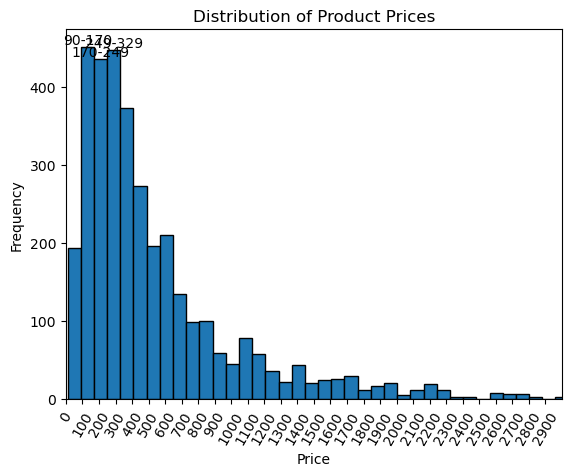

In [44]:
import matplotlib.pyplot as plt
import numpy as np

price_data = data_df['Price']

# Create histogram
n, bins, patches = plt.hist(price_data, bins=100, edgecolor='black')

# Set the x-axis limit
plt.xlim(0, 3000)

# Set the x-axis tick positions and labels
tick_positions = range(0, 3000, 100)
plt.xticks(tick_positions)
plt.xticks(rotation=60)

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')

# Add range labels to top three bars
top_n = 3
top_indices = np.argsort(n)[-top_n:]  # Indices of top n bars
for i in top_indices:
    # Get the range of values for each bar
    range_label = f'{bins[i]:.0f}-{bins[i + 1]:.0f}'
    # Position the label above the bar
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), range_label,
             ha='center', va='bottom')

# Display the plot
plt.show()

#Top 3 price ranges are 267 - 319, 319 - 371 and 110-162 


0          GIGABYTE
1          GIGABYTE
2            51Risc
3          GIGABYTE
4              ASUS
           ...     
3598    Refurbished
3599           DELL
3600    Refurbished
3601            MSI
3602           DELL
Name: new_brand, Length: 3603, dtype: object
0        859.99
1       1183.87
2        209.00
3       1149.99
4       2159.99
         ...   
3598      89.99
3599      43.00
3600      78.00
3601     204.28
3602      61.00
Name: Price, Length: 3603, dtype: float64


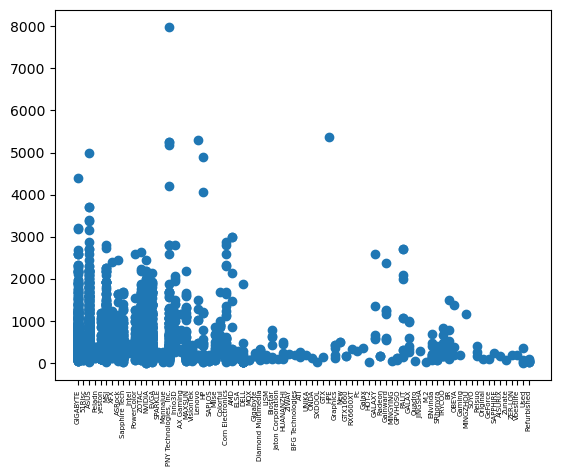

In [45]:
#draw the scatter plot Phân bố giá sản phẩm theo hãng
# Create scatter plot
x = data_df['new_brand']
y = data_df['Price']
plt.scatter(x, y)
plt.xticks(rotation=90,fontsize=5)

print(x)
print(y)

(0.0, 3000.0)

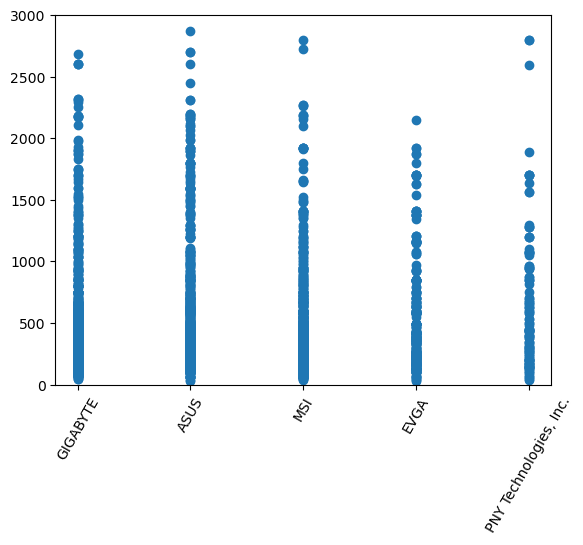

In [46]:
#draw the scatter plot Phân bố giá sản phẩm theo hãng
# Create scatter plot

#filter data fro selected_brand 
#Top 5 brands are MSI, GIGABYTE and ASUS, EVGA and PNY Technologies, Inc.
selected_brand = ['GIGABYTE','MSI','ASUS','EVGA','PNY Technologies, Inc.']
filtered_data = data_df[data_df['new_brand'].isin(selected_brand)]

#create x and y varaibles from filtered_data
x = filtered_data['new_brand']
y = filtered_data['Price']

# Create scatter plot
plt.scatter(x, y)
plt.xticks(rotation=60)

# Set the y-axis limit
plt.ylim(0, 3000)

#Phân bố giá sản phẩm theo top 5 brands: các hãng hàng đầu đều có range sản phẩm từ giá thấp đến giá cao

In [55]:
#Biểu diễn mối liên hệ giữa giá sản phẩm và rating của người dùng
#rating columns need to be transformed
rating = data_df['Rating']
print(rating.head(2))

0    Rating + 4.9
1    Rating + 4.3
Name: Rating, dtype: object


(0.0, 3000.0)

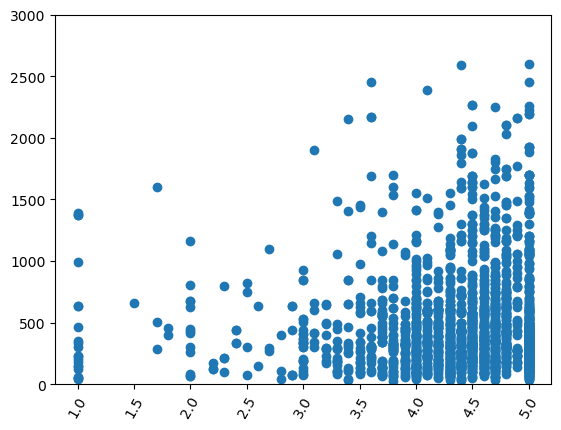

In [48]:
#scatter plot of price and new_rating, filtered all the NaNn number in column new_rating
#draw the scatter plot Phân bố giá sản phẩm theo hãng

# Create filtered dataframe, which filtered out the empty new_rating
rating_price_filtered_df = data_df[data_df['new_rating'].notna()][['Price','new_rating']]

#create scatter  plot
rating_price_filtered_df = rating_price_filtered_df.dropna(axis=1, how='all')

x = rating_price_filtered_df['new_rating']
y = rating_price_filtered_df['Price']
plt.scatter(x, y)
plt.xticks(rotation=60)

# Set the y-axis limit
plt.ylim(0, 3000)

In [49]:
data_df['new_rating'].min()
data_df['new_rating'].max()

5.0

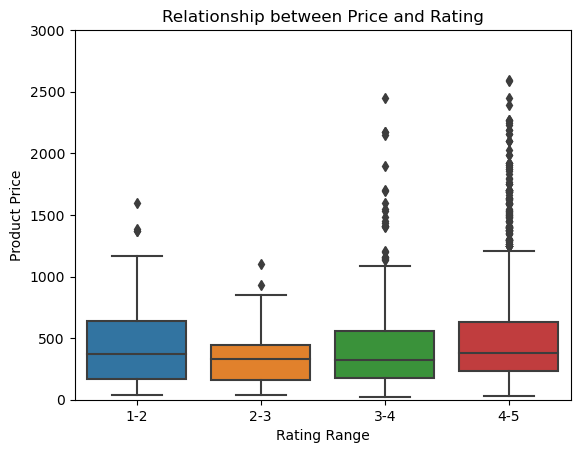

In [63]:
# Create filtered dataframe, which filtered out the empty new_rating
rating_price_filtered_df = data_df[data_df['new_rating'].notna()][['Price','rating_range']]

# Assuming you have a DataFrame called 'rating_price_filtered_df' with columns 'Price' and 'rating_range'
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'rating_price_filtered_df' with columns 'Price' and 'rating_range'

# Create box plot using Seaborn
sns.boxplot(x=rating_price_filtered_df['rating_range'], y=rating_price_filtered_df['Price'])

# Set labels and title
plt.xlabel('Rating Range')
plt.ylabel('Product Price')
plt.title('Relationship between Price and Rating')

#set the ylimit
plt.ylim(0,3000)

# Display the plot
plt.show()
